In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
from pathlib import Path
from shapely import from_wkt
import pedpy
import json
from jupedsim.internal.notebook_utils import read_sqlite_file
from shapely import from_wkt
import shapely
from typing import Optional, List, Tuple
import plotly.graph_objects as go

print(pedpy.__version__)

1.2.0


Agents: 85
../trajectories_croma/1C060_cam6_cam5_frameshift0_Combined.txt
frame_after_decrease = 3951
Data written to ../trajectories_croma/1C060_frame_3951.csv


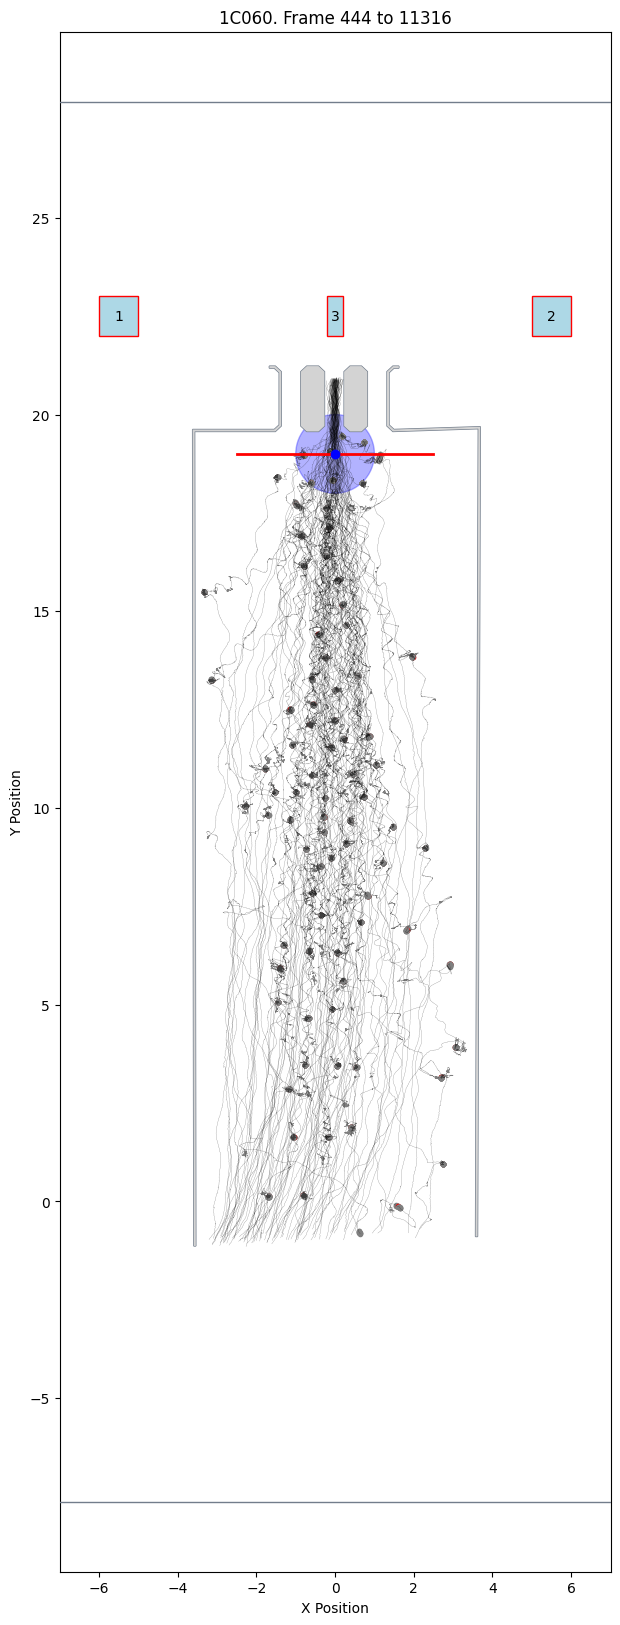

In [13]:
# Define the WKT string for the polygon
geometry = from_wkt(
    "POLYGON ((-8.88 -7.63, 8.3 -7.63, 8.3 27.95, -8.88 27.95, -8.88 -7.63), (-3.54 -1.13, -3.57 19.57, -1.52 19.57, -1.37 19.71, -1.37 21.09, -1.52 21.23, -1.67 21.23, -1.67 21.18, -1.545 21.18, -1.4200000000000002 21.065, -1.4200000000000002 19.735, -1.545 19.62, -3.6199999999999997 19.62, -3.59 -1.13, -3.54 -1.13), (3.57 -0.89, 3.64 19.64, 1.47 19.57, 1.32 19.71, 1.32 21.09, 1.47 21.23, 1.62 21.23, 1.62 21.18, 1.4949999999999999 21.18, 1.37 21.065, 1.37 19.735, 1.4949999999999999 19.62, 3.69 19.69, 3.6199999999999997 -0.89, 3.57 -0.89), (0.67 19.57, 0.82 19.71, 0.82 21.09, 0.67 21.23, 0.38 21.23, 0.23 21.09, 0.23 19.71, 0.38 19.57, 0.67 19.57), (-0.42 19.57, -0.27 19.71, -0.27 21.09, -0.42 21.23, -0.72 21.23, -0.87 21.09, -0.87 19.71, -0.72 19.57, -0.42 19.57))"
)
filenames = [
    "../trajectories_croma/1C060_cam6_cam5_frameshift0_Combined.txt",
    "../trajectories_croma/1C070_cam6_cam5_frameshift0_Combined.txt",
    "../trajectories_croma/2C070_cam6_cam5_frameshift0_Combined.txt",
    "../trajectories_croma/2C120_cam6_cam5_frameshift0_Combined.txt",
    "../trajectories_croma/2C130_cam6_cam5_frameshift0_Combined.txt",
    "../trajectories_croma/2C150_cam6_cam5_frameshift0_Combined.txt",
]
def read_json_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data


def get_first_frame_after_max_reached(filename):
    """Return the first frame after the number of pedestrians starts decreasing from max_ids."""
    df = pd.read_csv(
        filename, sep="\t", names=["id", "frame", "x", "y", "z", "m"], comment="#"
    )
    frames = np.unique(df["frame"])
    ids = np.unique(df["id"])
    max_ids = len(ids) - 2  # I don't knnow why 2 are missing
    max_reached = False

    for frame in range(frames.min(), frames.max() + 1):
        frame_data = df[df["frame"] == frame]
        count_in_frame = frame_data["id"].nunique()
        if count_in_frame >= max_ids:
            max_reached = True
            return df, frame - 1

        # Once max_ids has been reached, check if the number of pedestrians decreases
        if max_reached and count_in_frame == max_ids - 1:
            return df, frame - 1

    return pd.DataFrame(), None

def plot_trajectories_around_frame(
    df: pd.DataFrame,
    target_frame: int,
    num_frames: int = 10,
    title: str = "",
    geometry: Optional[shapely.Geometry] = None,
    inifile: str = 'files/inifile.json'
) -> None:
    """Plot trajectories for num_frames before and after the target frame."""
    fig, axes = create_figure()
    plot_pedestrian_trajectories(df, target_frame)
    plot_walkable_area(geometry)
    plot_doors_and_destinations(inifile)
    set_plot_properties(title, df)
    plt.show()

def filter_dataframe(df: pd.DataFrame, target_frame: int, num_frames: int) -> pd.DataFrame:
    """
    Filter the dataframe to include only the frames around the target frame.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing trajectory data.
    target_frame (int): The frame number to center the filter around.
    num_frames (int): The number of frames to include before and after the target frame.

    Returns:
    pd.DataFrame: A filtered DataFrame containing only the frames within the specified range.
    """
    start_frame = max(target_frame - num_frames, df["frame"].min())
    end_frame = min(target_frame + num_frames, df["frame"].max())
    return df[(df["frame"] >= start_frame) & (df["frame"] <= end_frame)]

def create_figure(num_rows=1, num_cols=1, fig_width=20, fig_height=20):
    """
    Create and return a figure and axes for plotting.

    Parameters:
    num_rows (int): Number of rows in the subplot grid. Default is 1.
    num_cols (int): Number of columns in the subplot grid. Default is 1.
    fig_width (int): Width of the figure in inches. Default is 20.
    fig_height (int): Height of the figure in inches. Default is 20.

    Returns:
    tuple: A tuple containing the figure and axes objects.
    """
    return plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))

def plot_pedestrian_trajectories(df: pd.DataFrame, target_frame: int, num_frames=10):
    """Plot the trajectories of all pedestrians in the filtered dataframe."""
    start_frame = max(target_frame - num_frames, df["frame"].min())
    end_frame = min(target_frame + num_frames, df["frame"].max())
    filtered_df = df[(df["frame"] >= start_frame) & (df["frame"] <= end_frame)]
    ids = np.unique(filtered_df["id"])
    for ped in ids:
        ped_data = df[df["id"] == ped]
        for frame in range(start_frame, end_frame + 1):
            color = "red" if frame == target_frame else "gray"
            frame_data = ped_data[ped_data["frame"] == frame]
            if not frame_data.empty:
                plt.plot(
                    frame_data["x"],
                    frame_data["y"],
                    ".",
                    color=color,
                    label=f"Ped {ped} at frame {frame}",
                )
        plt.plot(
            ped_data["x"],
            ped_data["y"],
            label=f"Ped {ped}",
            color="black",
            alpha=0.5,
            lw=0.2,
        )

def plot_walkable_area(geometry: shapely.Geometry):
    """
    Plot the walkable area defined by the given geometry.

    This function creates a WalkableArea object from the provided geometry
    and plots it using pedpy's plot_walkable_area function.

    Parameters:
    -----------
    geometry : shapely.Geometry
        A Shapely geometry object defining the walkable area.

    Returns:
    --------
    None
        The function plots the walkable area but does not return any value.

    Note:
    -----
    This function requires the pedpy library to be imported and available.
    """
    
    walkable_area = pedpy.WalkableArea(geometry)
    pedpy.plot_walkable_area(walkable_area=walkable_area)

def plot_doors_and_destinations(inifile: str):
    """Plot doors and destinations from the inifile."""
    data = read_json_file(inifile)
    plot_doors(data)
    plot_destinations(data)

def plot_doors(data: dict):
    """Plot doors from the inifile data."""
    motivation_doors = data["motivation_parameters"]["motivation_doors"]
    width = data["motivation_parameters"]["width"]
    for door in motivation_doors:
        vertices = door["vertices"]
        x_vals, y_vals = zip(*vertices)
        plt.plot(x_vals, y_vals, label=f"Door {door['id']}", color='red', lw=2)
        center_x, center_y = np.mean(x_vals), np.mean(y_vals)
        plt.plot(center_x, center_y, marker='o', color='b')
        circle = plt.Circle((center_x, center_y), width, color='b', alpha=0.3, fill=True)
        plt.gca().add_artist(circle)

def plot_destinations(data: dict):
    """Plot destinations from the inifile data."""
    for destination in data["destinations"]:
        vertices = destination["vertices"]
        polygon = plt.Polygon(vertices, closed=True, fill=True, edgecolor='r', facecolor='lightblue', label=f"Exit {destination['id']}")
        plt.gca().add_patch(polygon)
        centroid = [sum(x)/len(vertices) for x in zip(*vertices)]
        plt.text(centroid[0], centroid[1], f"{destination['id']}", ha='center', va='center', fontsize=10, color='black')

def set_plot_properties(title: str, filtered_df: pd.DataFrame):
    """Set the properties of the plot."""
    plt.xlim(-7, 7)
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    start_frame, end_frame = filtered_df["frame"].min(), filtered_df["frame"].max()
    plt.title(f"{title}. Frame {start_frame} to {end_frame}")
    plt.gca().set_aspect('equal')


def process_file(filename: str, geometry: shapely.geometry.Polygon) -> None:
    """Process the file and handle data extraction, plotting, and file output."""
    df: pd.DataFrame
    frame_after_decrease: Optional[int]
    df, frame_after_decrease = get_first_frame_after_max_reached(filename)
    print_agent_info(df, filename, frame_after_decrease)
    
    if frame_after_decrease is not None:
        write_frame_data_to_file(df, frame_after_decrease, filename)
        plot_trajectories_around_frame(
            df, frame_after_decrease, num_frames=10, title=extract_title(filename), geometry=geometry
        )
    else:
        print("No valid frame found for visualization.")


def print_agent_info(df: pd.DataFrame, filename: str, frame_after_decrease: Optional[int]) -> None:
    """Print information about the number of agents and the frame after the decrease."""
    print(f"Agents: {len(df['id'].unique())}")
    print(f"{filename}")
    print(f"{frame_after_decrease = }")


def extract_title(filename: str) -> str:
    """Extract the title from the filename (before the first underscore)."""
    return Path(filename).stem.split("_")[0]


def write_frame_data_to_file(df: pd.DataFrame, frame_after_decrease: int, filename: str) -> None:
    """Write the frame data to a CSV file."""
    frame_data: pd.DataFrame = df[df["frame"] == frame_after_decrease]
    tuple_list: List[Tuple[float, float]] = [tuple(x) for x in frame_data[['x', 'y']].to_numpy()]
    title: str = extract_title(filename)
    output_filename: str = f"../trajectories_croma/{title}_frame_{frame_after_decrease}.csv"
    
    with open(output_filename, 'w') as f:
        writer: csv.writer = csv.writer(f)
        writer.writerows(tuple_list)
    print(f"Data written to {output_filename}")


def process_files(filenames: List[str], geometry: shapely.geometry.Polygon) -> None:
    """Process a list of filenames."""
    for filename in filenames:
        process_file(filename, geometry)


process_files(filenames[0:1], geometry)

In [7]:
# Parse the WKT polygon
geometry2 = from_wkt(
    "POLYGON ((-8.88 -7.63, 8.3 -7.63, 8.3 27.95, -8.88 27.95, -8.88 -7.63), (-3.54 -1.13, -3.57 19.57, -1.52 19.57, -1.37 19.71,  -0.87 19.71, -0.72 19.57, -0.42 19.57, -0.27 19.71, -0.27 21.09, -0.42 21.23, -0.72 21.23, -0.87 21.09, -1.37 21.09, -1.52 21.23, -1.67 21.23, -1.67 21.18, -1.545 21.18, -1.4200000000000002 21.065, -1.4200000000000002 19.735, -1.545 19.62, -3.6199999999999997 19.62, -3.59 -1.13, -3.54 -1.13), (3.57 -0.89, 3.64 19.64, 1.47 19.57, 1.32 19.71, 0.82 19.71, 0.67 19.57, 0.38 19.57, 0.23 19.71, 0.23 21.09, 0.38 21.23, 0.67 21.23, 0.82 21.09, 1.32 21.09, 1.47 21.23, 1.62 21.23, 1.62 21.18, 1.4949999999999999 21.18, 1.37 21.065, 1.37 19.735, 1.4949999999999999 19.62, 3.69 19.69, 3.6199999999999997 -0.89, 3.57 -0.89))"
)


# Extract exterior coordinates
exterior_x, exterior_y = geometry2.exterior.xy

# Extract interior coordinates (holes)
interiors = [list(interior.coords.xy) for interior in geometry2.interiors]
exterior_x = list(geometry2.exterior.xy[0])
exterior_y = list(geometry2.exterior.xy[1])

# Extract interior coordinates (holes) as lists
interiors = [
    (list(interior.xy[0]), list(interior.xy[1])) for interior in geometry2.interiors
]

# Create the figure
fig = go.Figure()

# Plot exterior
fig.add_trace(go.Scatter(x=exterior_x, y=exterior_y, mode="lines", name="Exterior"))

# Plot interiors (holes)
for i, (x, y) in enumerate(interiors):
    fig.add_trace(go.Scatter(x=x, y=y, mode="lines+markers", name=f"Interior {i+1}"))
    print(f"Interior {i+1}. {x = }, {y = }")



# fig.add_trace(go.Scatter(x=combined_x, y=combined_y, mode='lines+markers', fill='toself', name='Combined Polygon'))

# Update layout
fig.update_layout(
    title="Polygon with Interior Holes",
    xaxis_title="X Coordinate",
    yaxis_title="Y Coordinate",
    showlegend=True,
    width=700,
    height=700,
)

fig.show()

Interior 1. x = [-3.54, -3.57, -1.52, -1.37, -0.87, -0.72, -0.42, -0.27, -0.27, -0.42, -0.72, -0.87, -1.37, -1.52, -1.67, -1.67, -1.545, -1.4200000000000002, -1.4200000000000002, -1.545, -3.6199999999999997, -3.59, -3.54], y = [-1.13, 19.57, 19.57, 19.71, 19.71, 19.57, 19.57, 19.71, 21.09, 21.23, 21.23, 21.09, 21.09, 21.23, 21.23, 21.18, 21.18, 21.065, 19.735, 19.62, 19.62, -1.13, -1.13]
Interior 2. x = [3.57, 3.64, 1.47, 1.32, 0.82, 0.67, 0.38, 0.23, 0.23, 0.38, 0.67, 0.82, 1.32, 1.47, 1.62, 1.62, 1.4949999999999999, 1.37, 1.37, 1.4949999999999999, 3.69, 3.6199999999999997, 3.57], y = [-0.89, 19.64, 19.57, 19.71, 19.71, 19.57, 19.57, 19.71, 21.09, 21.23, 21.23, 21.09, 21.09, 21.23, 21.23, 21.18, 21.18, 21.065, 19.735, 19.62, 19.69, -0.89, -0.89]


/var/folders/xp/t78pqmf50rb4s9vh6gdz0ykr0000gq/T/ipykernel_16697/1033981737.py:15: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.

/var/folders/xp/t78pqmf50rb4s9vh6gdz0ykr0000gq/T/ipykernel_16697/1033981737.py:15: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.

/var/folders/xp/t78pqmf50rb4s9vh6gdz0ykr0000gq/T/ipykernel_16697/1033981737.py:15: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.



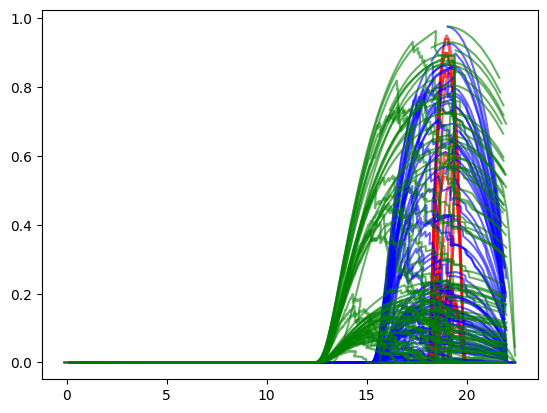

In [8]:
motiv_files = ['files/trajectory_variation_001_motivation.csv',
               #'files/trajectory_variation_002_motivation.csv',
               #'files/trajectory_variation_003_motivation.csv',
               'files/trajectory_variation_004_motivation.csv',
               #'files/trajectory_variation_005_motivation.csv',
               #'files/trajectory_variation_006_motivation.csv',
               'files/trajectory_variation_007_motivation.csv',
]
colors = ['red', 'blue', 'green', 'orange', 'purple', 'black', 'yellow']

for i, motiv_file in enumerate(motiv_files):
    df = pd.read_csv(motiv_file,  names=["frame", "id", "time", "motivation", "x", "y"])
    for id_to_plot in df["id"].unique():
        ped_data = df[df["id"] == id_to_plot]
        plt.plot(ped_data["y"], ped_data["motivation"],'-k', ms=1, alpha=0.6, color=colors[i])

    

0.9767817229883216


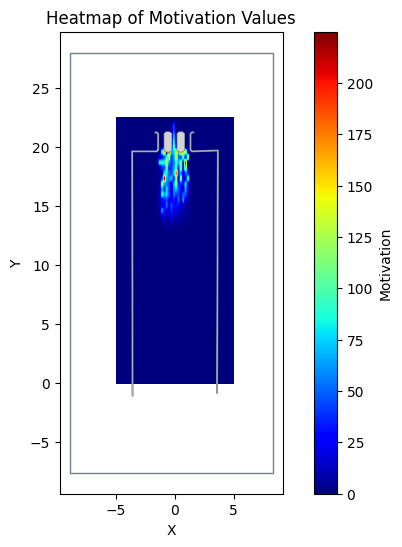

In [16]:

x_values = df["x"].to_numpy()
y_values = df["y"].to_numpy()
motivation_values = df["motivation"].to_numpy()
plt.figure(figsize=(8, 6))
heatmap, xedges, yedges = np.histogram2d(x_values, y_values, bins=50, weights=motivation_values)

plt.imshow(heatmap.T, origin='lower', cmap='jet', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plot_walkable_area(geometry)
plt.colorbar(label='Motivation')
print(max(motivation_values))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Heatmap of Motivation Values')
plt.show()